In [1]:
from transformers import CLIPProcessor, CLIPModel

# load pretrained model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
# load preprocessor for model input
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

## Run PyTorch model inference

In [15]:
with open("classes.txt", "r") as classes:
    lines = classes.readlines()
    
    input_classes = []
    
    for line in lines:
        input_labels = line.split(",")

In [6]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def visualize_result(image:Image, labels:List[str], probs:np.ndarray, top:int = 10):
    """ 
    Utility function for visualization classification results
    params:
      image: input image
      labels: list of classification labels
      probs: model predicted softmaxed probabilities for each label
      top: number of the highest probability results for visualization
    returns:
      None
    """
    plt.figure(figsize=(16, 12))
    top_labels = np.argsort(-probs)[:min(top, probs.shape[0])]
    top_probs = probs[top_labels]
    
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(2, 2, 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [labels[index] for index in top_labels], fontweight='bold')
    plt.xlabel("probability")
    
    plt.subplots_adjust(wspace=0.3) 


323.1009452342987


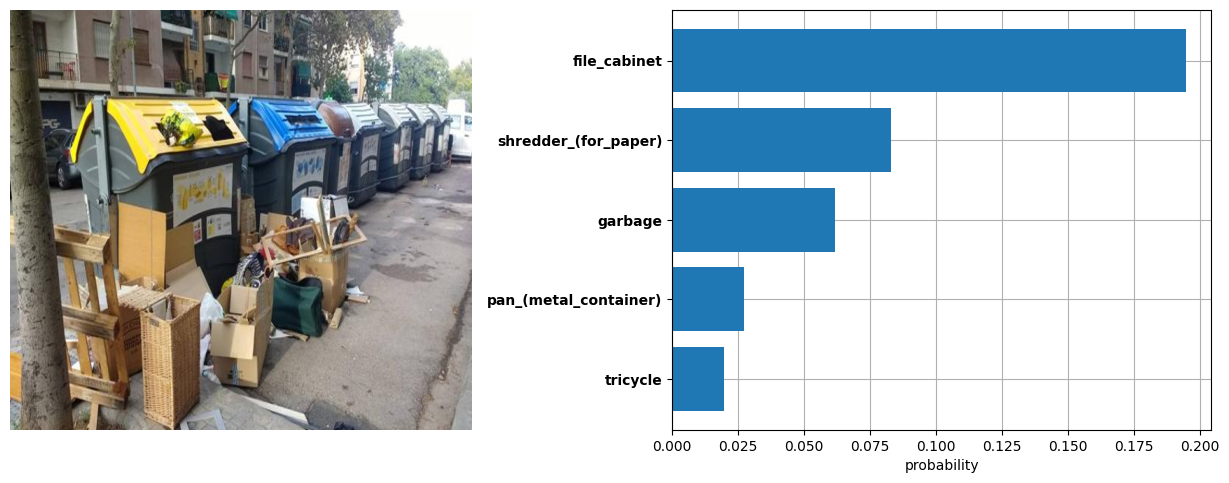

In [7]:
import time
startTime = time.time()

image = Image.open('18.jpg')
image = image.resize((660,600))
text_descriptions = [f"There is a {label} in this photo" for label in input_labels]

inputs = processor(text=text_descriptions, images=[image], return_tensors="pt", padding=True)

results = model(**inputs)
logits_per_image = results['logits_per_image']  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1).detach().numpy()  # we can take the softmax to get the label probabilities

visualize_result(image, input_labels, probs[0])

## Export to onnx format

In [7]:
import torch

torch.onnx.export(
    model,  # model being run
    # model input in one of acceptable format: torch.Tensor (for single input), tuple or list of tensors for multiple inputs or dictionary with string keys and tensors as values.
    dict(inputs),
    "clip-vit-base-patch16.onnx",  # where to save the model
    opset_version=14,  # the ONNX version to export the model to
    input_names=["input_ids", "pixel_values", "attention_mask"],  # the model's input names
    output_names=["logits_per_image", "logits_per_text", "text_embeds", "image_embeds"],  # the model's output names
    dynamic_axes={  # variable length axes
        "input_ids": {0: "batch", 1: "sequence"},
        "pixel_values": {0: "batch", 1: "num_channels", 2: "height", 3: "width"},
        "attention_mask": {0: "batch", 1: "sequence"},
        "logits_per_image": {0: "batch"},
        "logits_per_text": {0: "batch"},
        "text_embeds": {0: "batch"},
        "image_embeds": {0: "batch"}
    }
)

C:\Users\sapen\Desktop\Workspace\Roc4Tech\YOLOv8\yolov8-venv\lib\site-packages\transformers\models\clip\modeling_clip.py:280: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
C:\Users\sapen\Desktop\Workspace\Roc4Tech\YOLOv8\yolov8-venv\lib\site-packages\transformers\models\clip\modeling_clip.py:320: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
C:\Users\sapen\Desktop\Workspace\Roc4Tech\YOLOv8\yolov8-venv\lib\site-pac

## Run OpenVINO model

In [8]:
from openvino.runtime import serialize
from openvino.tools import mo

ov_model = mo.convert_model('clip-vit-base-patch16.onnx', compress_to_fp16=True)
serialize(ov_model, 'clip-vit-base-patch16.xml')

2.5199790000915527


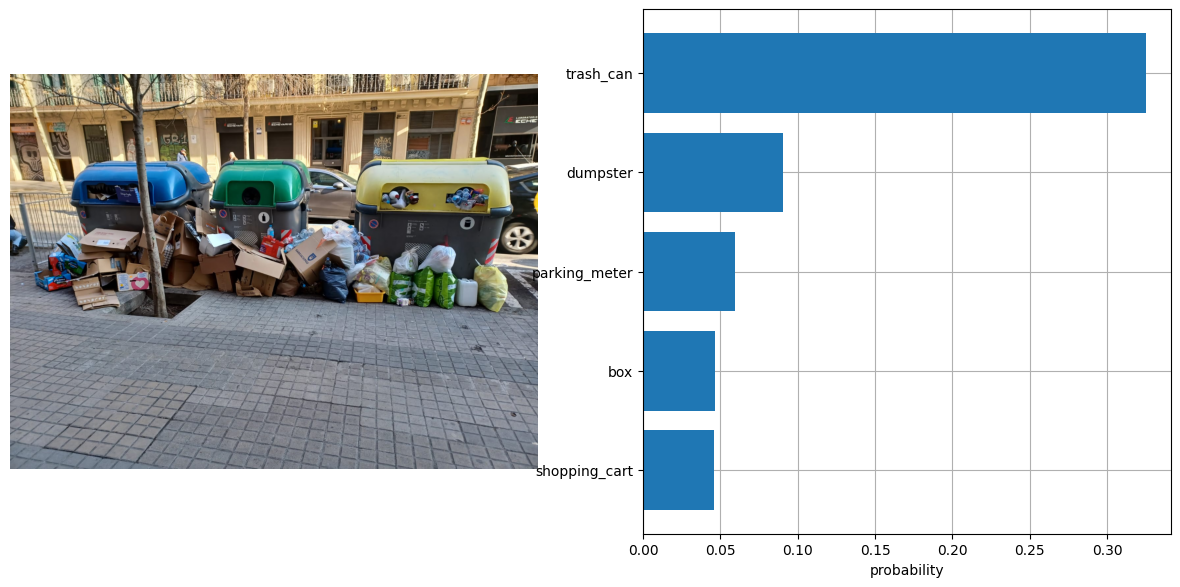

In [12]:
import numpy as np
from scipy.special import softmax
from openvino.runtime import Core

# create OpenVINO core object instance
core = Core()
# compile model for loading on device
compiled_model = core.compile_model(ov_model)
# obtain output tensor for getting predictions
logits_per_image_out = compiled_model.output(0)

startTime = time.time()

# run inference on preprocessed data and get image-text similarity score
ov_logits_per_image = compiled_model(dict(inputs))[logits_per_image_out]
# perform softmax on score
probs = softmax(ov_logits_per_image, axis=1)

endTime = time.time()

inf_time = endTime - startTime
print(inf_time)
# visualize prediction
visualize_result(image, input_label, probs[0])